# Example system: Solid State Synthesis

In [3]:
from labgraph import (
    Sample,
    Material,
    Action,
    Measurement,
    Analysis,
    Ingredient,
    WholeIngredient,
    Actor,
    AnalysisMethod,
)
import labgraph.views as views

In [4]:
sampleview = views.SampleView()

In [5]:
actorview = views.ActorView()  # this is our interface to the Actor database collection
labman = Actor(
    name="LabMan 30-105",
    tags=["SolidStateALab"],
    description="A robotic system that weighs and mixes powders in crucibles. Used to prepare samples for firing in furnaces. This is in building 30-105 at Lawrence Berkeley National Laboratory.",
)

tubefurnace1 = Actor(
    name="TubeFurnace1 30-105",
    tags=["SolidStateALab"],
    description="A tube furnace in building 30-105 at Lawrence Berkeley National Laboratory.",
)

aeris = Actor(
    name="Aeris 30-105",
    tags=["SolidStateALab"],
    description="An x-ray diffractometer. This is in building 30-105 at Lawrence Berkeley National Laboratory.",
)

operator = Actor(
    name="Operator",
    description="A generic actor for any operation performed by a human. No need to name names!",
)

actorview.add(labman)
actorview.add(tubefurnace1)
actorview.add(aeris)
actorview.add(operator)

ObjectId('6434517733972f30f89e9751')

In [6]:
analysismethodview = views.AnalysisMethodView()
cnn_phaseID = AnalysisMethod(
    name="CNN Phase ID",
    tags=["SolidStateALab", "machinelearning"],
    description="A convolutional neural network trained to identify phases in x-ray diffraction patterns. doi: something/something",
)

analysismethodview.add(cnn_phaseID)

ObjectId('6434517733972f30f89e975e')

Procurement

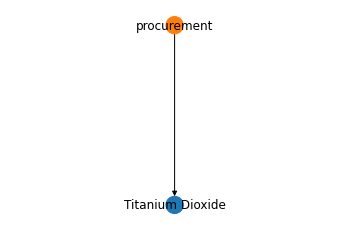

In [7]:
m0 = Material(
    name="Titanium Dioxide",
    formula="TiO2",
)

p0 = Action(
    name="procurement",
    generated_materials=[m0],
    actor=operator,
)
sample_procurement = Sample(
    name="20220111 Procurement",
    description="Procurement of TiO2 powder",
    nodes=[m0, p0],
)
sampleview.add(sample_procurement)
sample_procurement.plot()

Sample

In [6]:
p1 = Action(
    "grind",
    ingredients=[
        Ingredient(
            material=m0,
            amount=1,
            unit="g",
        )
    ],
    actor=operator,
)
m1 = p1.make_generic_generated_material()

p2 = Action("sinter", ingredients=[WholeIngredient(m1)], actor=tubefurnace1)
m2 = p2.make_generic_generated_material()

p3 = Action("grind", ingredients=[WholeIngredient(m2)], actor=operator, final_step=True)
m3 = p3.make_generic_generated_material()

me0 = Measurement(
    name="XRD",
    material=m3,
    actor=aeris,
)
a0 = Analysis(
    name="Phase Identification", measurements=[me0], analysis_method=cnn_phaseID
)

me1 = Measurement(name="XRD", material=m2, actor=aeris)
a1 = Analysis(
    name="Phase Identification", measurements=[me1], analysis_method=cnn_phaseID
)

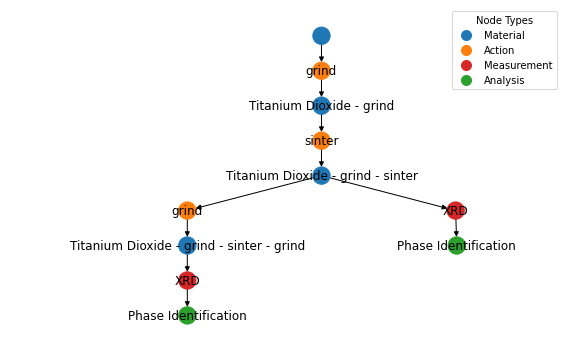

In [9]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

all_nodes = [p1, m1, p2, m2, p3, m3, me0, a0, me1, a1]

# if you have all nodes beforehand
s = Sample(name="first_sample", nodes=all_nodes)
fig, ax = plt.subplots(figsize=(8, 5))
s.plot(ax=ax)
plt.tight_layout()
plt.xlim(-50, 450)

kws = dict(marker="o", linestyle="", markersize=10)
legend_elements = [
    Line2D([0], [0], color=plt.cm.tab10(0), label="Material", **kws),
    Line2D([0], [0], color=plt.cm.tab10(1), label="Action", **kws),
    Line2D([0], [0], color=plt.cm.tab10(3), label="Measurement", **kws),
    Line2D([0], [0], color=plt.cm.tab10(2), label="Analysis", **kws),
]
# Create the figure
ax.legend(handles=legend_elements, loc="upper right", title="Node Types")
plt.savefig("example_sample_graph.png", dpi=150)
plt.show()
# sampleview.add(s)

# Allowed Node Relationships

In [8]:
import networkx as nx
from pathlib import Path

IMGDIR = Path("source/img")

In [9]:
import matplotlib.pyplot as plt

color_key = {
    nodetype: plt.cm.tab10(i)
    for i, nodetype in enumerate(["Material", "Action", "Analysis", "Measurement"])
}


def layout(g: nx.DiGraph, step=10):
    pos = {}

    for xi, generation in enumerate(nx.topological_generations(g)):
        ypos = [step * yi for yi in range(len(generation))]
        ypos = [y - sum(ypos) / len(ypos) for y in ypos[::-1]]
        for node, y in zip(generation, ypos):
            pos[node] = (xi * step, y)
    return pos


def zoom(ax, factor):
    def expand(l, r):
        center = (l + r) / 2
        width = (r - l) / 2
        return center - width * factor, center + width * factor

    ax.set_xlim(expand(*ax.get_xlim()))
    ax.set_ylim(expand(*ax.get_ylim()))


def plot_example(g: nx.DiGraph, ax=None, **kwargs):
    if ax is None:
        fig, ax = plt.subplots()
    # pos = graphviz_layout(g)
    pos = layout(g)
    ax.set_axis_off()
    colors = [color_key[g.nodes[n]["type"]] for n in g.nodes]
    nx.draw_networkx_nodes(g, pos, node_color=colors, ax=ax, **kwargs)
    nx.draw_networkx_edges(g, pos, ax=ax, **kwargs)
    labels = {n: n + "\n\n\n" for n in g.nodes}
    nx.draw_networkx_labels(g, pos, labels=labels, font_weight="bold", ax=ax, **kwargs)

    zoom(ax, 1.4)
    return ax

## Material

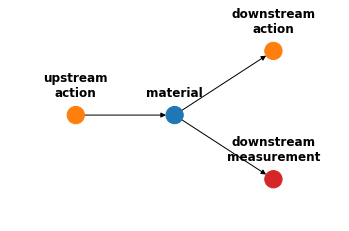

In [10]:
g = nx.DiGraph()

g.add_node("upstream\naction\n", type="Action")
g.add_node("material", type="Material")
g.add_node("downstream\naction\n", type="Action")
g.add_node("downstream\nmeasurement\n", type="Measurement")

g.add_edge("upstream\naction\n", "material")
g.add_edge("material", "downstream\naction\n")
g.add_edge("material", "downstream\nmeasurement\n")
plot_example(g)

plt.savefig(IMGDIR / "material_allowed_edges.png", bbox_inches="tight")

## Action

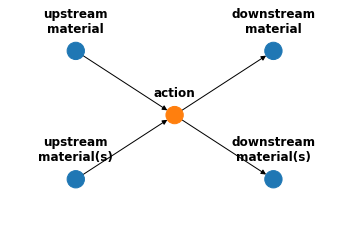

In [112]:
g = nx.DiGraph()

g.add_node("upstream\nmaterial\n", type="Material")
g.add_node("upstream\nmaterial(s)\n", type="Material")
g.add_node("action", type="Action")
g.add_node("downstream\nmaterial\n", type="Material")
g.add_node("downstream\nmaterial(s)\n", type="Material")

g.add_edge("upstream\nmaterial\n", "action")
g.add_edge("upstream\nmaterial(s)\n", "action")
g.add_edge("action", "downstream\nmaterial\n")
g.add_edge("action", "downstream\nmaterial(s)\n")
plot_example(g)

plt.savefig(IMGDIR / "action_allowed_edges.png", bbox_inches="tight")

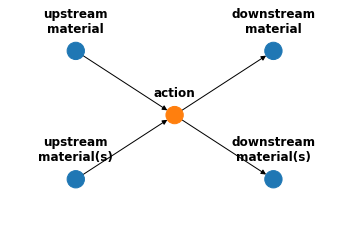

In [113]:
g = nx.DiGraph()

g.add_node("upstream\nmaterial\n", type="Material")
g.add_node("upstream\nmaterial(s)\n", type="Material")
g.add_node("action", type="Action")
g.add_node("downstream\nmaterial\n", type="Material")
g.add_node("downstream\nmaterial(s)\n", type="Material")

g.add_edge("upstream\nmaterial\n", "action")
g.add_edge("upstream\nmaterial(s)\n", "action")
g.add_edge("action", "downstream\nmaterial\n")
g.add_edge("action", "downstream\nmaterial(s)\n")
plot_example(g)

plt.savefig(IMGDIR / "action_allowed_edges.png", bbox_inches="tight")

## Measurement

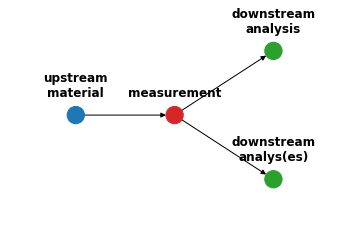

In [114]:
g = nx.DiGraph()

g.add_node("upstream\nmaterial\n", type="Material")
g.add_node("measurement", type="Measurement")
g.add_node("downstream\nanalysis\n", type="Analysis")
g.add_node("downstream\nanalys(es)\n", type="Analysis")

g.add_edge("upstream\nmaterial\n", "measurement")
g.add_edge("measurement", "downstream\nanalysis\n")
g.add_edge("measurement", "downstream\nanalys(es)\n")
plot_example(g)

plt.savefig(IMGDIR / "measurement_allowed_edges.png", bbox_inches="tight")

## Analysis

<AxesSubplot:>

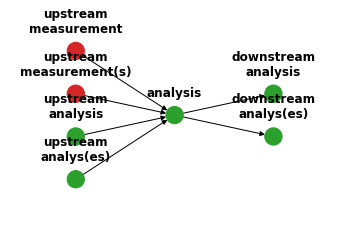

In [13]:
g = nx.DiGraph()

g.add_node("upstream\nmeasurement\n", type="Measurement")
g.add_node("upstream\nmeasurement(s)\n", type="Measurement")
g.add_node("upstream\nanalysis\n", type="Analysis")
g.add_node("upstream\nanalys(es)\n", type="Analysis")
g.add_node("analysis", type="Analysis")
g.add_node("downstream\nanalysis\n", type="Analysis")
g.add_node("downstream\nanalys(es)\n", type="Analysis")

g.add_edge("upstream\nmeasurement\n", "analysis")
g.add_edge("upstream\nmeasurement(s)\n", "analysis")
g.add_edge("upstream\nanalysis\n", "analysis")
g.add_edge("upstream\nanalys(es)\n", "analysis")
g.add_edge("analysis", "downstream\nanalysis\n")
g.add_edge("analysis", "downstream\nanalys(es)\n")
plot_example(g)

# plt.savefig(IMGDIR/"analysis_allowed_edges.png" ,bbox_inches="tight")

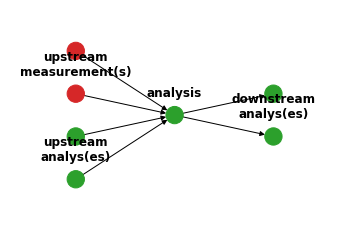

In [22]:
g = nx.DiGraph()

g.add_node("   ", type="Measurement")
g.add_node("upstream\nmeasurement(s)\n", type="Measurement")
g.add_node(" ", type="Analysis")
g.add_node("upstream\nanalys(es)\n", type="Analysis")
g.add_node("analysis", type="Analysis")
g.add_node("downstream\nanalys(es)\n", type="Analysis")
g.add_node("  ", type="Analysis")

g.add_edge("upstream\nmeasurement(s)\n", "analysis")
g.add_edge("   ", "analysis")
g.add_edge("upstream\nanalys(es)\n", "analysis")
g.add_edge(" ", "analysis")
g.add_edge("analysis", "  ")
g.add_edge("analysis", "downstream\nanalys(es)\n")
plot_example(g)

plt.savefig(IMGDIR / "analysis_allowed_edges.png", bbox_inches="tight")

Custom legend

(0.0, 1.0, 0.0, 1.0)

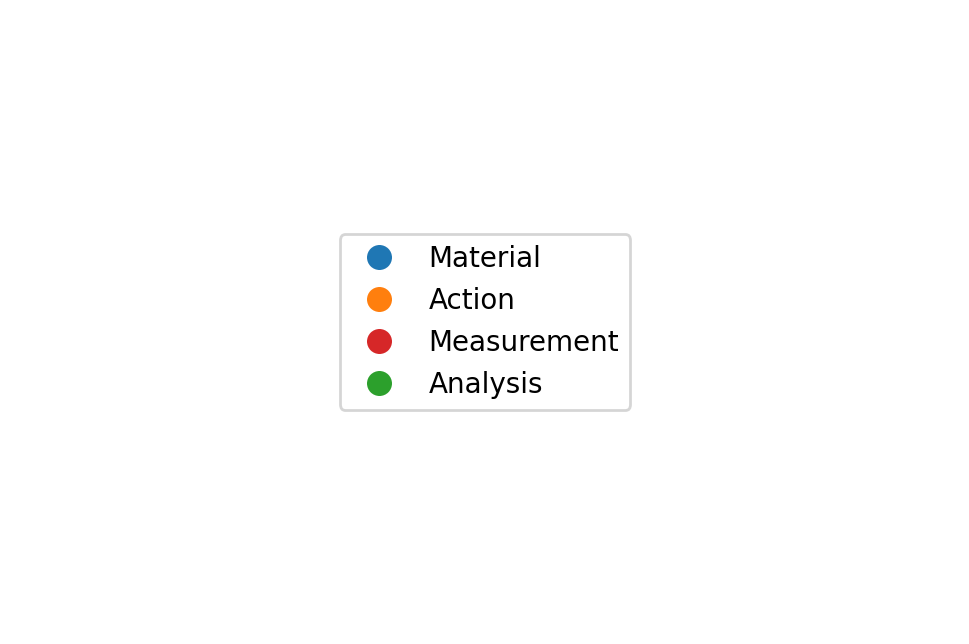

In [23]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

legend_handles = [
    Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        label="Material",
        markerfacecolor="tab:blue",
        markersize=10,
    ),
    Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        label="Action",
        markerfacecolor="tab:orange",
        markersize=10,
    ),
    Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        label="Measurement",
        markerfacecolor="tab:red",
        markersize=10,
    ),
    Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        label="Analysis",
        markerfacecolor="tab:green",
        markersize=10,
    ),
]

plt.figure(dpi=200)
plt.legend(handles=legend_handles, loc="center", ncol=1)
plt.axis("off")

## Example Linear Experiment

In [64]:
import matplotlib.pyplot as plt

color_key = {
    nodetype: plt.cm.tab10(i)
    for i, nodetype in enumerate(["Material", "Action", "Analysis", "Measurement"])
}
# def layout(g:nx.DiGraph, step=10):
#     pos = {}

#     for xi, generation in enumerate(nx.topological_generations(g)):
#         ypos = [step*yi for yi in range(len(generation))]
#         ypos = [y - sum(ypos)/len(ypos) for y in ypos[::-1]]
#         for node, y in zip(generation, ypos):
#             pos[node] = (xi*step, y)
#     return pos


def zoom(ax, factor):
    def expand(l, r):
        center = (l + r) / 2
        width = (r - l) / 2
        return center - width * factor, center + width * factor

    ax.set_xlim(expand(*ax.get_xlim()))
    ax.set_ylim(expand(*ax.get_ylim()))


def plot_example(g: nx.DiGraph, pos: dict, ax=None, **kwargs):
    if ax is None:
        fig, ax = plt.subplots()
    # pos = graphviz_layout(g)
    ax.set_axis_off()
    colors = [color_key[g.nodes[n]["type"]] for n in g.nodes]
    nx.draw_networkx_nodes(g, pos, node_color=colors, ax=ax, **kwargs)
    nx.draw_networkx_edges(g, pos, alpha=0.2, ax=ax, **kwargs)
    labels = {n: ncontents["name"] + "\n\n\n" for n, ncontents in g.nodes(data=True)}
    nx.draw_networkx_labels(g, pos, labels=labels, font_weight="bold", ax=ax, **kwargs)

    zoom(ax, 1.4)
    return ax

In [65]:
from uuid import uuid4


def add_node(name: str, follows: list, x: float, y: float, type: str):
    uid = str(uuid4())
    g.add_node(uid, name=name, type=type)
    positions[uid] = (x, y)
    for f in follows:
        g.add_edge(f, uid)
    return uid


def add_measurement(name: str, follows: list, x: float, y: float):
    return add_node(name, follows, x, y, "Measurement")


def add_analysis(name: str, follows: list, x: float, y: float):
    return add_node(name, follows, x, y, "Analysis")


def add_action(name: str, follows: list, x: float, y: float):
    return add_node(name, follows, x, y, "Action")


def add_material(name: str, follows: list, x: float, y: float):
    return add_node(name, follows, x, y, "Material")

In [66]:
positions = {}
g = nx.DiGraph()

In [67]:
# synthesis
p0 = add_action("procurement", [], 0, 0)
m0 = add_material("reagent 1", [p0], 0, -1)
p1 = add_action("procurement", [], 2, 0)
m1 = add_material("reagent 2", [p1], 2, -1)

mix = add_action("mix", [m0, m1], 1, -2)
mixed_intermediate = add_material("mixture", [mix], 1, -3)
heat = add_action("heat", [mixed_intermediate], 1, -4)
product = add_material("cathode", [heat], 1, -5)

xrd = add_measurement("diffraction", [product], 0.5, -6)
phase_id = add_analysis("phase identification", [xrd], 0, -7)

<AxesSubplot:>

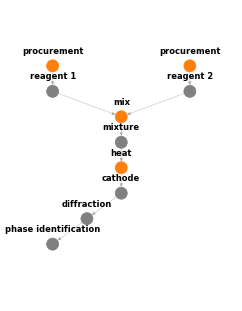

In [68]:
fig, ax = plt.subplots(figsize=(6, 8), dpi=50)
# plot_example(g, positions, ax = ax)
plot_example_actiongraph(g, positions, ax=ax)
# plt.savefig(IMGDIR/"example_handoff.png", bbox_inches="tight")

In [42]:
positions = {}
g = nx.DiGraph()

In [43]:
# synthesis
p0 = add_action("procurement", [], 0, 0)
m0 = add_material("reagent 1", [p0], 0, -1)
p1 = add_action("procurement", [], 2, 0)
m1 = add_material("reagent 2", [p1], 2, -1)

mix = add_action("mix", [m0, m1], 1, -2)
mixed_intermediate = add_material("mixture", [mix], 1, -3)
heat = add_action("heat", [mixed_intermediate], 1, -4)
intermediate = add_material("intermediate", [heat], 1, -5)
grind = add_action("grind", [intermediate], 1, -6)
product = add_material("cathode", [grind], 1, -7)

xrd = add_measurement("diffraction", [product], 0.5, -8)
phase_id = add_analysis("phase identification", [xrd], 0, -9)

<AxesSubplot:>

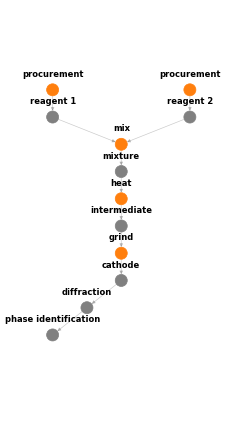

In [50]:
fig, ax = plt.subplots(figsize=(6, 11), dpi=50)
# plot_example(g, positions, ax = ax)
plot_example_actiongraph(g, positions, ax=ax)
# plt.savefig(IMGDIR/"example_handoff.png", bbox_inches="tight")

## Example Handoff Experiment

In [48]:
import matplotlib.pyplot as plt

color_key = {
    nodetype: plt.cm.tab10(i)
    for i, nodetype in enumerate(["Material", "Action", "Analysis", "Measurement"])
}
# def layout(g:nx.DiGraph, step=10):
#     pos = {}

#     for xi, generation in enumerate(nx.topological_generations(g)):
#         ypos = [step*yi for yi in range(len(generation))]
#         ypos = [y - sum(ypos)/len(ypos) for y in ypos[::-1]]
#         for node, y in zip(generation, ypos):
#             pos[node] = (xi*step, y)
#     return pos


def zoom(ax, factor):
    def expand(l, r):
        center = (l + r) / 2
        width = (r - l) / 2
        return center - width * factor, center + width * factor

    ax.set_xlim(expand(*ax.get_xlim()))
    ax.set_ylim(expand(*ax.get_ylim()))


def plot_example(g: nx.DiGraph, pos: dict, ax=None, **kwargs):
    if ax is None:
        fig, ax = plt.subplots()
    # pos = graphviz_layout(g)
    ax.set_axis_off()
    colors = [color_key[g.nodes[n]["type"]] for n in g.nodes]
    nx.draw_networkx_nodes(g, pos, node_color=colors, ax=ax, **kwargs)
    nx.draw_networkx_edges(g, pos, alpha=0.2, ax=ax, **kwargs)
    labels = {n: ncontents["name"] + "\n\n\n" for n, ncontents in g.nodes(data=True)}
    nx.draw_networkx_labels(g, pos, labels=labels, font_weight="bold", ax=ax, **kwargs)

    zoom(ax, 1.4)
    return ax


def plot_example_actiongraph(g: nx.DiGraph, pos: dict, ax=None, **kwargs):
    if ax is None:
        fig, ax = plt.subplots()
    # pos = graphviz_layout(g)
    ax.set_axis_off()
    colors = [
        color_key[g.nodes[n]["type"]]
        if g.nodes[n]["type"] == "Action"
        else plt.cm.gray(0.5)
        for n in g.nodes
    ]
    nx.draw_networkx_nodes(g, pos, node_color=colors, ax=ax, **kwargs)
    nx.draw_networkx_edges(g, pos, alpha=0.2, ax=ax, **kwargs)
    labels = {n: ncontents["name"] + "\n\n\n" for n, ncontents in g.nodes(data=True)}
    nx.draw_networkx_labels(g, pos, labels=labels, font_weight="bold", ax=ax, **kwargs)

    zoom(ax, 1.4)
    return ax

In [49]:


def add_node(name: str, follows: list, x: float, y: float, type: str):
    uid = str(uuid4())
    g.add_node(uid, name=name, type=type)
    positions[uid] = (x, y)
    for f in follows:
        g.add_edge(f, uid)
    return uid


def add_measurement(name: str, follows: list, x: float, y: float):
    return add_node(name, follows, x, y, "Measurement")


def add_analysis(name: str, follows: list, x: float, y: float):
    return add_node(name, follows, x, y, "Analysis")


def add_action(name: str, follows: list, x: float, y: float):
    return add_node(name, follows, x, y, "Action")


def add_material(name: str, follows: list, x: float, y: float):
    return add_node(name, follows, x, y, "Material")

In [56]:
positions = {}
g = nx.DiGraph()

In [57]:
# #synthesis
# p0 = add_action("procurement", [], 0, 0)
# m0 = add_material("reagent 1", [p0], 0, -1)
# p1 = add_action("procurement", [], 2, 0)
# m1 = add_material("reagent 2", [p1], 2, -1)

# mix = add_action("mix", [m0, m1], 1, -2)
# mixed_intermediate = add_material("mixture", [mix], 1, -3)
# heat = add_action("heat", [mixed_intermediate], 1, -4)
product = add_material("cathode", [], 1, -5)

# xrd = add_measurement("diffraction", [product], 0.5, -6)
# # phase_id = add_analysis("phase identification", [xrd], 0, -7)

In [58]:
# coincell testing
p2 = add_action("procurement", [], 3, -4)
separator = add_material("separator", [p2], 3, -5)
cr2032 = add_material("anode", [p2], 2, -5)
electrolyte = add_material("electrolyte", [p2], 4, -5)

coincellfab = add_action(
    "coin cell\nfabrication", [separator, cr2032, electrolyte, product], 2, -6.5
)
coincell = add_material("coin cell", [coincellfab], 2, -7.5)
cycling = add_measurement("cycling", [coincell], 2, -8.5)
capacity = add_analysis("capacity", [cycling], 1.5, -9.5)
lifetime = add_analysis("lifetime", [cycling], 2.5, -9.5)

<AxesSubplot:>

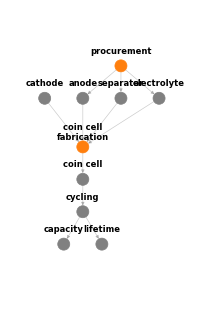

In [63]:
fig, ax = plt.subplots(figsize=(5, 8), dpi=50)
# plot_example(g, positions, ax = ax)
plot_example_actiongraph(g, positions, ax=ax)
# plt.savefig(IMGDIR/"example_handoff.png", bbox_inches="tight")